# EDA y Limpieza inicial
**Prueba técnica – Ingeniero de Datos**

Este notebook realiza una exploración rápida del dataset, identifica problemas de calidad y documenta hallazgos que servirán para el script ETL.

In [ ]:
# Permitir importaciones desde la carpeta raíz del proyecto
import sys, pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent 
sys.path.append(str(PROJECT_ROOT))

from SRC.config import RAW_CSV_PATH, CLEAN_PARQUET_PATH, CLEAN_DATA_DIR


PROJECT_ROOT: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf
RAW_CSV_PATH: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA\dataset_salud_500k.csv
CLEAN_DATA_DIR: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA
CLEAN_PARQUET_PATH: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA\clean_dataset.parquet
None


In [ ]:
# ----------------------------------------------------------------------------
# 1. Importaciones y parámetros globales
#    - Carga las librerías base para el EDA.
#    - Define estilo de gráficos y muestra aleatoria a analizar (20 %).
# ----------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use("default")
pd.set_option("display.max_columns", None)

SAMPLE_FRAC = 0.20
RANDOM_STATE = 42

In [ ]:
# ----------------------------------------------------------------------------
# 2. Carga del CSV completo y generación de una muestra aleatoria
#    - df_full  : dataset original (≈ 500 000 filas)
#    - df       : muestra del 20 % para exploración rápida
# ----------------------------------------------------------------------------

%%time
df_full = pd.read_csv(RAW_CSV_PATH, low_memory=False)
df = df_full.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Shape completo: {df_full.shape} | Muestra: {df.shape}")
display(df.head())
display(df.info(memory_usage='deep'))


Shape completo: (500000, 16) | Muestra: (100000, 16)


,patient_id,age,gender,visit_date,specialty,diagnosis,procedure,doctor_id,hospital_id,city,country,visit_type,visit_duration_minutes,outcome,readmission_within_30_days,cost_usd
0,866c67c5-f03d-444f-ba72-f4bfefb4367b,114,F,2025-04-22,Medicina Interna,Deleniti ipsam.,Doloribus ab.,e67d8f3d-4c18-4571-b24c-92033569163c,ae73b705-1656-46e7-9ad6-5d8bed40a2fc,Santiago,República Dominicana,Hospitalización,254,Fallecimiento,0,4468.89
1,10eeade2-d4ec-47e3-95dd-d82f00220b12,57,NaN,2023-02-18,Pediatra,Architecto.,Est.,d6554988-b0cd-4b3e-9eb1-f9e9faa34bfd,082503ad-1936-4b4c-bf8e-05b7394d782b,Quito,Perú,Emergencia,371,Fallecimiento,0,775.99
2,5b1f3cfc-ede6-4644-bb69-b8fc4d4890fb,125,M,2021-04-30,Ortopedia,Natus earum sunt repellat.,Et sapiente.,53cb463c-1bc9-4c37-8ca3-51f285b1dcab,a2f4d56a-595c-453d-802b-dbc2ab321288,Ciudad de México,Ecuador,Emergencia,122,Alta,0,1013.59
3,8b95b065-8ebb-46b9-879a-f5d04cf8f3e1,96,M,2020-10-14,Cirujia,Sit ex.,Facilis.,5851ae54-33cf-4c96-b9a7-cce02a3c4482,4c5ae9b9-cfec-40f6-94fb-729c11021e4a,Lima,Perú,Consulta,357,Fallecimiento,0,358.97
4,6cd7f9ae-3edb-4da1-9eef-8430eb8fe9a6,122,M,2025-06-09,Pediatría,Molestiae vel.,Provident similique.,2e95fe15-6a0d-43b7-a4d7-3e6f41c438af,8e7e5b1e-5327-4cb2-bd2c-b3733ecc91d8,Lima,Ecuador,Emergencia,396,Referencia,0,4807.41


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   patient_id                  100000 non-null  object 
 1   age                         100000 non-null  int64  
 2   gender                      95941 non-null   object 
 3   visit_date                  100000 non-null  object 
 4   specialty                   100000 non-null  object 
 5   diagnosis                   100000 non-null  object 
 6   procedure                   100000 non-null  object 
 7   doctor_id                   100000 non-null  object 
 8   hospital_id                 100000 non-null  object 
 9   city                        100000 non-null  object 
 10  country                     100000 non-null  object 
 11  visit_type                  99014 non-null   object 
 12  visit_duration_minutes      100000 non-null  int64  
 13  outcome        

None

CPU times: total: 3.58 s
Wall time: 3.62 s



## Principales hallazgos del EDA rápido

| Métrica | Valor aproximado |
|---------|------------------|
| Filas totales | 500 000 |
| Columnas | 16 |
| Nulos — `gender` | ~4 % |
| Nulos — `visit_type` | ~1 % |
| Edades negativas o >120 | ~6 % |
| Costos = 0 USD | ~1 % |
| Costos > 50 000 USD | <1 % |
| Especialidades con typos | `Cardiolgia`, `Ginecplogía`, `Cirujia`, `Pediatra` |
| Duplicados exactos | 0 % |


In [ ]:
# ----------------------------------------------------------------------------
# 3. Resumen estadístico
#    - describe() para variables numéricas y categóricas.
#    - Permite detectar rangos, medias y desviaciones inusuales.
# ----------------------------------------------------------------------------

# Resumen numérico
num_cols = df.select_dtypes(include='number').columns
display(df[num_cols].describe().T)

# Resumen categórico
cat_cols = df.select_dtypes(exclude='number').columns
display(df[cat_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
age,100000.0,59.611130,40.494985,-10.0,25.000,60.000,95.0000,129.0000
visit_duration_minutes,100000.0,300.866420,171.770469,5.0,152.000,300.000,449.0000,599.0000
readmission_within_30_days,100000.0,0.152990,0.359980,0.0,0.000,0.000,0.0000,1.0000
cost_usd,100000.0,3520.193533,10355.732514,0.0,1234.695,2514.395,3777.9025,109986.0328


,count,unique,top,freq
patient_id,100000,100000,9170cba6-0f24-4f6b-a38f-710ec9468186,1
gender,95941,2,M,48171
visit_date,100000,1857,2024-12-22,77
specialty,100000,14,Ginecología,7309
diagnosis,100000,74022,Recusandae.,64
procedure,100000,26082,Molestiae.,324
doctor_id,100000,100000,96de9099-d82d-4fcd-a1f4-a3406260ccda,1
hospital_id,100000,100000,e565bac3-5925-428b-83da-6b6dc8476cd1,1
city,100000,7,Quito,14437
country,100000,7,Ecuador,14458


In [ ]:
# ----------------------------------------------------------------------------
# 4. Análisis de valores faltantes
#    - Calcula % de nulos por columna y los ordena de mayor a menor.
#    - Sirve para priorizar imputaciones o descartes.
# ----------------------------------------------------------------------------

missing = (df.isna().mean()*100).round(2).sort_values(ascending=False)
display(missing.to_frame('pct_missing'))


,pct_missing
gender,4.06
visit_type,0.99
age,0.00
patient_id,0.00
specialty,0.00
diagnosis,0.00
procedure,0.00
visit_date,0.00
doctor_id,0.00
hospital_id,0.00


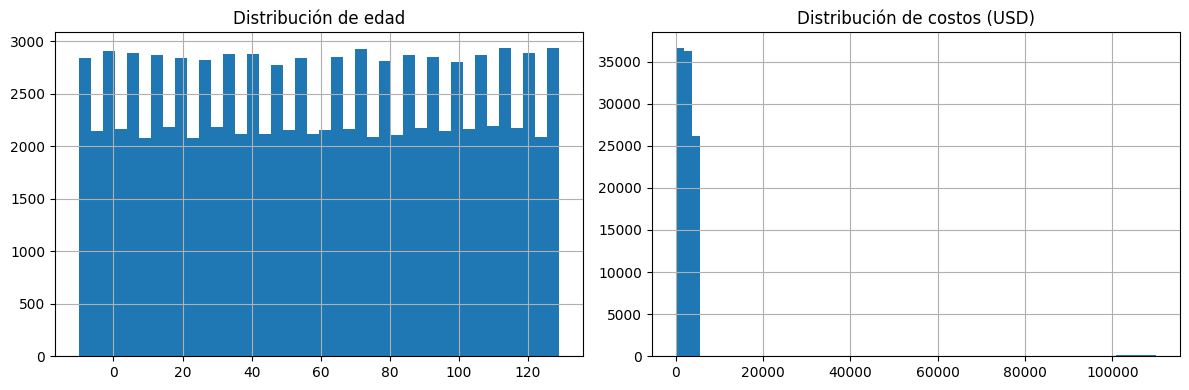

In [ ]:
# ----------------------------------------------------------------------------
# 5. Histogramas de variables clave
#    - Edad (age)   → distribución de pacientes.
#    - Costos (cost_usd) → dispersión de gastos médicos.
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12,4))
df['age'].dropna().hist(bins=40, ax=axes[0])
axes[0].set_title('Distribución de edad')

df['cost_usd'].dropna().hist(bins=60, ax=axes[1])
axes[1].set_title('Distribución de costos (USD)')
plt.tight_layout()



## Transformaciones y limpieza

A continuación se aplican reglas mínimas para preparar **`df_clean`**:

1. Columnas a `snake_case`.<br>
2. Conversión `visit_date` a fecha válida.<br>
3. Filtrado de edades (0–120).<br>
4. Eliminación de costos negativos, imputación de nulos con la mediana.<br>
5. `gender` faltante → `'unknown'`.<br>
6. Normalización de especialidades con mapa de typos.<br>
7. Guardado a Parquet.


In [ ]:
# ----------------------------------------------------------------------------
# 6. Limpieza y normalización del DataFrame (df_clean)
#     1) Columnas a snake_case.
#     2) Conversión de fechas y filtrado de edades 0-120.
#     3) Costos ≥ 0 e imputación con la mediana.
#     4) Relleno de gender faltante con 'unknown'.
#     5) Corrección de typos en specialty.
#     6) Exporta archivo limpio a Parquet.
# ----------------------------------------------------------------------------


from SRC.config import CLEAN_DATA_DIR, CLEAN_PARQUET_PATH
CLEAN_DATA_DIR.mkdir(parents=True, exist_ok=True)

df_clean = df_full.copy()

# 1. snake_case columnas
df_clean.columns = (
    df_clean.columns
            .str.strip()
            .str.lower()
            .str.replace(r'[^a-z0-9]+', '_', regex=True)
            .str.strip('_')
)

# 2. visit_date
df_clean['visit_date'] = pd.to_datetime(df_clean['visit_date'], errors='coerce')
df_clean = df_clean.dropna(subset=['visit_date'])

# 3. edades válidas
df_clean['age'] = pd.to_numeric(df_clean['age'], errors='coerce')
df_clean = df_clean[df_clean['age'].between(0, 120, inclusive='both')]

# 4. costos
df_clean['cost_usd'] = pd.to_numeric(df_clean['cost_usd'], errors='coerce')
df_clean = df_clean[df_clean['cost_usd'] >= 0]
median_cost = df_clean['cost_usd'].median()
df_clean['cost_usd'] = df_clean['cost_usd'].fillna(median_cost)

# 5. gender
df_clean['gender'] = df_clean['gender'].fillna('unknown')

# 6. normalización especialidades
typo_map = {
    'Cardiolgia': 'Cardiología',
    'Ginecplogía': 'Ginecología',
    'Cirujia': 'Cirugía',
    'Pediatra': 'Pediatría'
}
df_clean['specialty'] = df_clean['specialty'].replace(typo_map)

# 7. Guardar
out_path = CLEAN_PARQUET_PATH  # from config Path('clean_dataset.parquet')
df_clean.to_parquet(out_path, index=False)
print(f'Parquet guardado en {out_path.resolve()} – filas resultantes: {len(df_clean):,}')


Parquet guardado en C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA\clean_dataset.parquet – filas resultantes: 432,010
